In [45]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

allowed_color = 'Green'
polylog_color = 'Black'
noyhat_color = 'Orange'
giantstep_color = 'Blue'
notallowed_color = 'Red'
processnotdefined_color = 'Purple'
sweetspot_color = 'cyan'

In [46]:
from giant_learning.poly_poly import SphericalH3H3Overlaps
from giant_learning.gradient_descent import SphericalGradientDescent

import numpy as np
from sklearn.preprocessing import normalize
from scipy.linalg import orth

p = 1
k = 1
ds = np.array([32,64,128])
T = 5000
# T = 3
noise = 1e-6
ts = 1./np.sqrt(ds)  
seeds = 10
npower = 1.5
load = True

target = SphericalH3H3Overlaps._target
activation = SphericalH3H3Overlaps._activation
activation_derivative = SphericalH3H3Overlaps._activation_derivative


sim_plainsgd_test_errors = np.zeros((len(ds),seeds,T+1))
sim_correlationsgd_test_errors = np.zeros((len(ds),seeds,T+1))
sim_adaptivesgd_test_errors = np.zeros((len(ds),seeds,T+1))
theo_plainsgd_test_errors = np.zeros((len(ds),seeds,T+1))
theo_correlationsgd_test_errors = np.zeros((len(ds),seeds,T+1))
theo_adaptivesgd_test_errors = np.zeros((len(ds),seeds,T+1))


if load:
    data = np.load(f'simulations_T{T}_n{npower}_seeds{seeds}.npz')
    sim_plainsgd_test_errors = data['sim_plainsgd_test_errors']
    sim_correlationsgd_test_errors = data['sim_correlationsgd_test_errors']
    ds = data['ds']
    T = data['T']
    seeds = data['seeds']
    ts = data['ts']
    noise = data['noise']
    p = data['p']
    k = data['k']
    print('Data loaded')
else:
    for i,d,t in zip(range(len(ds)),ds,ts):
        for seed in range(seeds):
            n = int(d**npower)
            gamma = .05*n*np.power(d,-3/2)
            ## Initial conditions
            rng = np.random.default_rng(seed^d)
            Wtarget = orth((normalize(rng.normal(size=(k,d)), axis=1, norm='l2')).T).T
            Wtild = normalize(rng.normal(size=(p,d)), axis=1, norm='l2')
            Wtild_target = np.einsum('ji,ri,rh->jh', Wtild , Wtarget ,Wtarget)
            W0_orth =  normalize(Wtild - Wtild_target, axis=1, norm='l2')
            W0 = (t*normalize(Wtild_target,norm='l2',axis=1) + np.sqrt(1-t**2)*W0_orth)
            

            P = Wtarget @ Wtarget.T
            M0 = W0 @ Wtarget.T
            Q0 = W0 @ W0.T

            print(f'P = {P}')
            print(f'M0 = {M0}')
            print(f'Q0 = {Q0}')
            a0 = np.sign(M0[0][0])*np.ones(p) ### It is changed with the new version of the package. The 1/p is included in giant-learning ###

            gd_plain = SphericalGradientDescent(
                target, Wtarget, n,
                activation, W0, a0, activation_derivative,
                gamma, noise, predictor_interaction=True,
                test_size = None, analytical_error= 'H3H3'
            )

            gd_corr = SphericalGradientDescent(
                target, Wtarget, n,
                activation, W0, a0, activation_derivative,
                gamma, noise, predictor_interaction=False,
                test_size = None, analytical_error= 'H3H3',
            )

            gd_plain.train(T, verbose = True)
            gd_corr.train(T, verbose = True)

            sim_plainsgd_test_errors[i,seed,:] = np.array(gd_plain.test_errors)
            sim_correlationsgd_test_errors[i,seed,:] = np.array(gd_corr.test_errors)


    np.savez(f'simulations_T{T}_n{npower}_seeds{seeds}.npz', sim_plainsgd_test_errors = sim_plainsgd_test_errors, sim_correlationsgd_test_errors = sim_correlationsgd_test_errors, ds = ds, T = T, seeds = seeds, ts = ts, noise = noise, p = p, k = k)






Data loaded


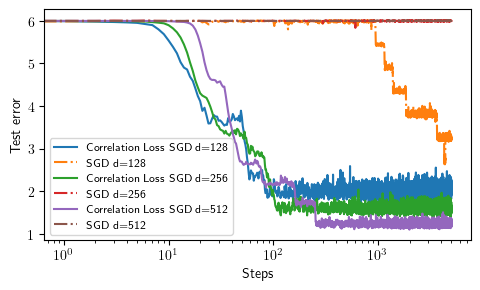

In [64]:
fig, ax = plt.subplots(1,1,figsize=(5.5,3))

colors = ['blue', 'orange', 'cyan', 'red', 'green', 'yellow', 'black']

for i,d in zip(range(len(ds)),ds):
    # ax.plot(sim_adaptivesgd_test_errors/R0, label=f'Adaptive SGD', marker='', ls='-', color='green')
    cl = ax.plot(np.arange(T+1),np.mean(sim_correlationsgd_test_errors[i], axis =0), label=f'Correlation Loss SGD d={d}', marker='', ls='-')
    ax.plot(np.arange(T+1),np.mean(sim_plainsgd_test_errors[i], axis =0), label=f'SGD d={d}', marker='', ls='-.')
    # cl = ax.plot(np.arange(T+1),sim_correlationsgd_test_errors[i].T, label=f'Correlation Loss SGD d={d}', marker='', ls='-',alpha=.3,color=colors[2*i])
    # ax.plot(np.arange(T+1),sim_plainsgd_test_errors[i].T, label=f'SGD d={d}', marker='', ls='-.',alpha=.3,color=colors[2*i+1])

# ax.plot(theo_adaptivesgd_test_errors, label=f'Adaptive SGD Theory', marker='', linestyle='-', color='green')
# ax.plot(theo_correlationsgd_test_errors, label=f'Correlation Loss SGD Theory', marker='', linestyle='-', color='blue')
# ax.plot(theo_plainsgd_test_errors, label=f'SGD Theory', marker='', linestyle='-', color='red')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Steps')
ax.set_ylabel('Test error')
# ax.set_xlim([0,110])
# ax.set_ylim([4.,6.2])
ax.legend(fontsize=8, loc='lower left')

plt.savefig('figures/different_SGDs.pdf', bbox_inches = 'tight')

